## 我们的任务 ##

垃圾邮件检测是机器学习在现今互联网领域的主要应用之一。几乎所有大型电子邮箱服务提供商都内置了垃圾邮件检测系统，能够自动将此类邮件分类为“垃圾邮件”。

在此项目中，我们将使用朴素贝叶斯算法创建一个模型，该模型会通过我们对模型的训练将信息[数据集](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)分类为垃圾信息或非垃圾信息。对垃圾文本信息进行大致了解十分重要。通常它们都包含“免费”、“赢取”、“获奖者”、“现金”、“奖品”等字眼，因为这些它们专门用来吸引你的注意力，诱惑你打开信息。此外，垃圾信息的文字一般都使用大写形式和大量感叹号。收信人能轻易辨认垃圾信息，而我们的目标是训练模型帮助我们识别垃圾信息！

能够识别垃圾信息是一种二元分类问题，因为此处信息只有“垃圾信息”或“非垃圾信息”这两种分类。此外，这是一种监督式学习问题，因为我们会向模型中提供带标签数据集，模型能够从中学习规律并在日后做出预测。 

### 第 0 步：朴素贝叶斯定理简介 ###

贝叶斯定理是最早的概率推理算法之一，由 Reverend Bayes 提出（他用来推理上帝是否存在），该定理在某些用例中依然很有用。

理解该定理的最佳方式是通过一个例子来讲解。假设你是一名特勤人员，你接到任务，需要在共和党总统候选人的某次竞选演说中保护他/她的安全。这场竞选演说是所有人都可以参加的公开活动，你的任务并不简单，需要时刻注意危险是否存在。一种方式是对每个人都设定一个威胁因子，根据人的特征（例如年龄、性别，是否随身带包以及紧张程度等等），你可以判断此人是否存在威胁。

如果某人符合所有这些特征，已经超出了你内心中的疑虑阈值，你可以采取措施并将此人带离活动现场。贝叶斯定理的原理也是如此，我们将根据某些相关事件（某人的年龄、性别、是否带包了、紧张程度等）的发生概率计算某个事件（某人存在威胁）的概率。 

你还需要考虑这些特征之间的独立性。例如，如果在活动现场，有个孩子看起来很紧张，那么与紧张的成人相比，孩子存在威胁的可能性会更低。为了深入讲解这一点，看看下面两个特征：年龄和紧张程度。假设我们单独研究这些特征，我们可以设计一个将所有紧张的人视作潜在威胁人士的模型。但是，很有可能会有很多假正例，因为现场的未成年人很有可能会紧张。因此同时考虑年龄和“紧张程度”特征肯定会更准确地反映哪些人存在威胁。

这就是该定理的“朴素”一词的含义，该定理会认为每个特征相互之间都保持独立，但实际上并非始终是这样，因此会影响到最终的结论。

简而言之，贝叶斯定理根据某些其他事件（在此例中是信息被分类为垃圾信息）的联合概率分布计算某个事件（在此例中是信息为垃圾信息）的发生概率。稍后我们将深入了解贝叶斯定理的原理，但首先了解下我们将处理的数据。

### 第 1.1 步：了解我们的数据集 ### 


我们将使用来自 UCI 机器学习资源库中的[数据集](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)，该资源库有大量供实验性研究的精彩数据集。[这是](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/)直接数据链接。


**下面是该数据的预览：** 

<img src="images/dqnb.png" height="1242" width="1242">

数据集中的列目前没有命名，可以看出有 2 列。

第一列有两个值：“ham”，表示信息不是垃圾信息，以及“spam”，表示信息是垃圾信息。

第二列是被分类的信息的文本内容。

>**说明：**
* 使用 read_table 方法将数据集导入 pandas 数据帧。因为这是一个用制表符分隔的数据集，因此我们将使用“\t”作为“sep”参数的值，表示这种分隔格式。
* 此外，通过为 read_table() 的“names”参数指定列表 ['label, 'sms_message']，重命名列。
* 用新的列名输出数据帧的前五个值。

In [2]:
'''
Solution
'''
import pandas as pd
# Dataset from - https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
df = pd.read_table('l4_15_SMSSpamCollection',
                   sep='\t', 
                   header=None, 
                   names=['label', 'sms_message'])

# Output printing out first 5 columns
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 第 1.2 步：数据预处理 ###

我们已经大概了解数据集的结构，现在将标签转换为二元变量，0 表示“ham”（即非垃圾信息），1表示“spam”，这样比较方便计算。

你可能会疑问，为何要执行这一步？答案在于 scikit-learn 处理输入的方式。Scikit-learn 只处理数字值，因此如果标签值保留为字符串，scikit-learn 会自己进行转换（更确切地说，字符串标签将转型为未知浮点值）。

如果标签保留为字符串，模型依然能够做出预测，但是稍后计算效果指标（例如计算精确率和召回率分数）时可能会遇到问题。因此，为了避免稍后出现意外的陷阱，最好将分类值转换为整数，再传入模型中。 

>**说明：**
* 使用映射方法将“标签”列中的值转换为数字值，如下所示：
{'ham':0, 'spam':1} 这样会将“ham”值映射为 0，将“spam”值映射为 1。
* 此外，为了知道我们正在处理的数据集有多大，使用“shape”输出行数和列数。

In [3]:
'''
Solution
'''
# 使用map将ham和spam的值改为0，1
df['label'] = df.label.map({'ham':0, 'spam':1})
print(df.shape)
df.head() # returns (rows, columns)

(5572, 2)


,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 第 2.1 步：Bag of words ###

我们的数据集中有大量文本数据（5,572 行数据）。大多数机器学习算法都要求传入的输入是数字数据，而电子邮件/信息通常都是文本。

现在我们要介绍 Bag of Words (BoW) 这个概念，它用来表示要处理的问题具有“大量单词”或很多文本数据。BoW 的基本概念是拿出一段文本，计算该文本中单词的出现频率。注意：BoW 平等地对待每个单词，单词的出现顺序并不重要。

利用我们将介绍的流程，我们可以将文档集合转换成矩阵，每个文档是一行，每个单词（令牌）是一列，对应的（行，列）值是每个单词或令牌在此文档中出现的频率。

例如：

假设有四个如下所示的文档：

`['Hello, how are you!',
'Win money, win from home.',
'Call me now',
'Hello, Call you tomorrow?']`

我们的目标是将这组文本转换为频率分布矩阵，如下所示：

**Jupyter 可以在文件中封装图像，比如下面的这个图就是封装到ipynb文件中的**

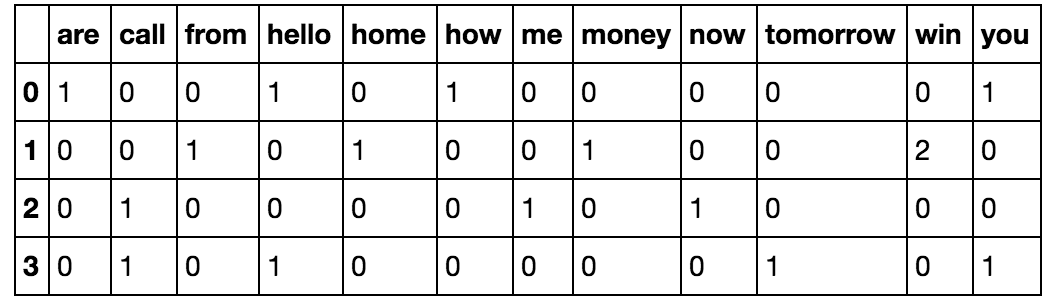

从图中可以看出，文档在行中进行了编号，每个单词是一个列名称，相应的值是该单词在文档中出现的频率。

我们详细讲解下，看看如何使用一小组文档进行转换。

要处理这一步，我们将使用 sklearns 
[count vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) 方法，该方法的作用如下所示：

* 它会令牌化字符串（将字符串划分为单个单词）并为每个令牌设定一个整型 ID。
* 它会计算每个令牌的出现次数。

**请注意：** 

* CountVectorizer 方法会自动将所有令牌化单词转换为小写形式，避免区分“He”和“he”等单词。为此，它会使用参数 `lowercase`，该参数默认设为 `True`。

* 它还会忽略所有标点符号，避免区分后面有标点的单词（例如“hello!”）和前后没有标点的同一单词（例如“hello”）。为此，它会使用参数 `token_pattern`，该参数使用默认正则表达式选择具有 2 个或多个字母数字字符的令牌。

* 要注意的第三个参数是 `stop_words`。停用词是指某个语言中最常用的字词，包括“am”、“an”、“and”、“the”等。 通过将此参数值设为 `english`，CountVectorizer 将自动忽略（输入文本中）出现在 scikit-learn 中的内置英语停用词列表中的所有单词。这非常有用，因为当我们尝试查找表明是垃圾内容的某些单词时，停用词会使我们的结论出现偏差。

我们将在之后的步骤中深入讲解在模型中应用每种预处理技巧的效果，暂时先知道在处理文本数据时，有这些预处理技巧可采用。

### 第 2.2 步：从头实现 Bag of Words ###

在深入了解帮助我们处理繁重工作的 scikit-learn 的 Bag of Words(BoW) 库之前，首先我们自己实现该步骤，以便了解该库的背后原理。 

**第 1 步：将所有字符串转换成小写形式。**

假设有一个文档集合：

In [5]:
documents = ['Hello, how are you!',
             'Win money, win from home.',
             'Call me now.',
             'Hello, Call hello you tomorrow?']

>**说明：**
* 将文档集合中的所有字符串转换成小写形式。将它们保存到叫做“lower_case_documents”的列表中。你可以使用 lower() 方法在 python 中将字符串转换成小写形式。

In [6]:
'''
Solution:
'''
documents = ['Hello, how are you!',
             'Win money, win from home.',
             'Call me now.',
             'Hello, Call hello you tomorrow?']

lower_case_documents = []
for i in documents:
    lower_case_documents.append(i.lower())
print(lower_case_documents)
# 将word转换为小写

['hello, how are you!', 'win money, win from home.', 'call me now.', 'hello, call hello you tomorrow?']


**第 2 步：删除所有标点符号**

>**说明：**
>删除文档集合中的字符串中的所有标点。将它们保存在叫做“sans_punctuation_documents”的列表中。

In [66]:
'''
Solution:
'''
sans_punctuation_documents = []
import string

for i in lower_case_documents:
    sans_punctuation_documents.append(i.translate(str.maketrans('', '', string.punctuation)))
print(sans_punctuation_documents)

['hello how are you', 'win money win from home', 'call me now', 'hello call hello you tomorrow']


**第 3 步：令牌化**

令牌化文档集合中的句子是指使用分隔符将句子拆分成单个单词。分隔符指定了我们将使用哪个字符来表示单词的开始和结束位置（例如，我们可以使用一个空格作为我们的文档集合的单词分隔符。）

>>**说明：**
>>使用 split() 方法令牌化“sans_punctuation_documents”中存储的字符串，并将最终文档集合存储在叫做“preprocessed_documents”的列表中。

In [10]:
'''
Solution:
'''
preprocessed_documents = []
for i in sans_punctuation_documents:
    preprocessed_documents.append(i.split(' '))
print(preprocessed_documents)

[['hello', 'how', 'are', 'you'], ['win', 'money', 'win', 'from', 'home'], ['call', 'me', 'now'], ['hello', 'call', 'hello', 'you', 'tomorrow']]


In [11]:
[['hello', 'how', 'are', 'you'], ['win', 'money', 'win', 'from', 'home'], ['call', 'me', 'now'], ['hello', 'call', 'hello', 'you', 'tomorrow']]


[['hello', 'how', 'are', 'you'],
 ['win', 'money', 'win', 'from', 'home'],
 ['call', 'me', 'now'],
 ['hello', 'call', 'hello', 'you', 'tomorrow']]

**第 4 步：计算频率**

我们已经获得所需格式的文档集合，现在可以数出每个单词在文档集合的每个文档中出现的次数了。为此，我们将使用 Python `collections` 库中的 `Counter` 方法。

`Counter` 会数出列表中每项的出现次数，并返回一个字典，键是被数的项目，相应的值是该项目在列表中的计数。 

>>**说明：**
  使用 Counter() 方法和作为输入的 preprocessed_documents 创建一个字典，键是每个文档中的每个单词，相应的值是该单词的出现频率。将每个 Counter 字典当做项目另存到一个叫做“frequency_list”的列表中。

In [12]:
'''
Solution
'''
frequency_list = []
import pprint
from collections import Counter

for i in preprocessed_documents:
    frequency_counts = Counter(i)
    frequency_list.append(frequency_counts)
pprint.pprint(frequency_list)

[Counter({'hello': 1, 'how': 1, 'are': 1, 'you': 1}),
 Counter({'win': 2, 'money': 1, 'from': 1, 'home': 1}),
 Counter({'call': 1, 'me': 1, 'now': 1}),
 Counter({'hello': 2, 'call': 1, 'you': 1, 'tomorrow': 1})]


In [13]:
[Counter({'hello': 1, 'how': 1, 'are': 1, 'you': 1}),
 Counter({'win': 2, 'money': 1, 'from': 1, 'home': 1}),
 Counter({'call': 1, 'me': 1, 'now': 1}),
 Counter({'hello': 2, 'call': 1, 'you': 1, 'tomorrow': 1})]


[Counter({'hello': 1, 'how': 1, 'are': 1, 'you': 1}),
 Counter({'win': 2, 'money': 1, 'from': 1, 'home': 1}),
 Counter({'call': 1, 'me': 1, 'now': 1}),
 Counter({'hello': 2, 'call': 1, 'you': 1, 'tomorrow': 1})]

恭喜！你从头实现了 Bag of Words 流程！正如在上一个输出中看到的，我们有一个频率分布字典，清晰地显示了我们正在处理的文本。

我们现在应该充分理解 scikit-learn 中的 `sklearn.feature_extraction.text.CountVectorizer` 方法的背后原理了。

我们将在下一步实现 `sklearn.feature_extraction.text.CountVectorizer` 方法。

### 第 2.3 步：在 scikit-learn 中实现 Bag of Words ###

我们已经从头实现了 BoW 概念，并使用 scikit-learn 以简洁的方式实现这一流程。我们将使用在上一步用到的相同文档集合。

In [14]:
'''
Here we will look to create a frequency matrix on a smaller document set to make sure we understand how the 
document-term matrix generation happens. We have created a sample document set 'documents'.
'''
documents = ['Hello, how are you!',
                'Win money, win from home.',
                'Call me now.',
                'Hello, Call hello you tomorrow?']

>>**说明：**
  导入 sklearn.feature_extraction.text.CountVectorizer 方法并创建一个实例，命名为 'count_vector'。

In [35]:
'''
Solution
'''
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

**使用 CountVectorizer() 预处理数据**

在第 2.2 步，我们从头实现了可以首先清理数据的 CountVectorizer() 方法。清理过程包括将所有数据转换为小写形式，并删除所有标点符号。CountVectorizer() 具有某些可以帮助我们完成这些步骤的参数，这些参数包括：

* `lowercase = True`

`lowercase` 参数的默认值为 `True`，它会将所有文本都转换为小写形式。


* `token_pattern = (?u)\\b\\w\\w+\\b`

`token_pattern` 参数具有默认正则表达式值 `(?u)\\b\\w\\w+\\b`，它会忽略所有标点符号并将它们当做分隔符，并将长度大于等于 2 的字母数字字符串当做单个令牌或单词。


* `stop_words`

`stop_words` 参数如果设为 `english`，将从文档集合中删除与 scikit-learn 中定义的英语停用词列表匹配的所有单词。考虑到我们的数据集规模不大，并且我们处理的是信息，并不是电子邮件这样的更庞大文本来源，因此我们将不设置此参数值。

你可以通过如下所示输出 `count_vector` 对象，查看该对象的所有参数值：

In [19]:
'''
Practice node:
Print the 'count_vector' object which is an instance of 'CountVectorizer()'
'''
print(count_vector)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


In [28]:
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
# 原始文件中 dtype会报错 invalid syntax
# dtype=<class ‘numpy.int64’>
# 官方文档 https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# dtype有默认属性，可以不写这个参数

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

>>**说明：**
>>使用 fit() 将你的文档数据集与 CountVectorizer 对象进行拟合，并使用 get_feature_names() 方法获得被归类为特征的单词列表。

In [29]:
'''
Solution:
'''
count_vector.fit(documents)
count_vector.get_feature_names()

['are',
 'call',
 'from',
 'hello',
 'home',
 'how',
 'me',
 'money',
 'now',
 'tomorrow',
 'win',
 'you']

In [30]:
['are',
 'call',
 'from',
 'hello',
 'home',
 'how',
 'me',
 'money',
 'now',
 'tomorrow',
 'win',
 'you']



['are',
 'call',
 'from',
 'hello',
 'home',
 'how',
 'me',
 'money',
 'now',
 'tomorrow',
 'win',
 'you']

`get_feature_names()` 方法会返回此数据集的特征名称，即组成 'documents' 词汇表的单词集合。

>>**
>>说明：**
>>创建一个矩阵，行是 4 个文档中每个文档的行，列是每个单词。对应的值（行，列）是该单词（在列中）在特定文档（在行中）中出现的频率。为此，你可以使用 transform() 方法并传入文档数据集作为参数。transform() 方法会返回一个 numpy 整数矩阵，你可以使用 toarray() 将其转换为数组，称之为 'doc_array'

In [31]:
'''
Solution
'''
doc_array = count_vector.transform(documents).toarray()
doc_array

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1]])

现在，对于单词在文档中的出现频率，我们已经获得了整洁的文档表示形式。为了方便理解，下一步我们会将此数组转换为数据帧，并相应地为列命名。

>>**说明：**
>>将我们获得并加载到 'doc_array' 中的数组转换为数据帧，并将列名设为单词名称（你之前使用 get_feature_names() 计算了名称）。将该数据帧命名为 'frequency_matrix'。

In [33]:
'''
Solution
'''
frequency_matrix = pd.DataFrame(doc_array, 
                                columns = count_vector.get_feature_names())
frequency_matrix

,are,call,from,hello,home,how,me,money,now,tomorrow,win,you
0,1,0,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,2,0
2,0,1,0,0,0,0,1,0,1,0,0,0
3,0,1,0,2,0,0,0,0,0,1,0,1


恭喜！你为我们创建的文档数据集成功地实现了 Bag of Words 问题。

直接使用该方法的一个潜在问题是如果我们的文本数据集非常庞大（假设有一大批新闻文章或电子邮件数据），由于语言本身的原因，肯定有某些值比其他值更常见。例如“is”、“the”、“an”等单词、代词、语法结构等会使矩阵出现偏斜并影响到分析结果。

有几种方式可以减轻这种情况。一种方式是使用 `stop_words` 参数并将其值设为 `english`。这样会自动忽略 scikit-learn 中的内置英语停用词列表中出现的所有单词（来自输入文本）。

另一种方式是使用 [tfidf](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) 方法。该方法已经超出了这门课程的讲解范畴。

### 第 3.1 步：训练集和测试集 ###

我们已经知道如何处理 Bag of Words 问题，现在回到我们的数据集并继续我们的分析工作。第一步是将数据集拆分为训练集和测试集，以便稍后测试我们的模型。


>>**说明：**
>>通过在 sklearn 中使用 train_test_split 方法，将数据集拆分为训练集和测试集。使用以下变量拆分数据：
* `X_train` 是 'sms_message' 列的训练数据。
* `y_train` 是 'label' 列的训练数据
* `X_test` 是 'sms_message' 列的测试数据。
* `y_test` 是 'label' 列的测试数据。
输出每个训练数据和测试数据的行数。

In [36]:
'''
Solution

NOTE: sklearn.cross_validation will be deprecated soon to sklearn.model_selection 
'''
# split into training and testing sets
# USE from sklearn.model_selection import train_test_split to avoid seeing deprecation warning.
# from sklearn.cross_validation import train_test_split
# 上面的是旧版本，新版本引入如下
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['sms_message'], 
                                                    df['label'], 
                                                    random_state=1)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4179
Number of rows in the test set: 1393


### 第 3.2 步：对数据集应用 Bag of Words 流程。 ###

我们已经拆分了数据，下个目标是按照第 2 步：Bag of words 中的步骤操作，并将数据转换为期望的矩阵格式。为此，我们将像之前一样使用 CountVectorizer()。我们需要完成两步：

* 首先，我们需要对 `CountVectorizer()`拟合训练数据 (`X_train`) 并返回矩阵。
* 其次，我们需要转换测试数据 (`X_test`) 以返回矩阵。

注意：`X_train` 是数据集中 'sms_message' 列的训练数据，我们将使用此数据训练模型。

`X_test` 是 'sms_message' 列的测试数据，我们将使用该数据（转换为矩阵后）进行预测。然后在后面的步骤中将这些预测与 `y_test` 进行比较。

我们暂时为你提供了进行矩阵转换的代码！

In [38]:
'''
[Practice Node]

The code for this segment is in 2 parts. Firstly, we are learning a vocabulary dictionary for the training data 
and then transforming the data into a document-term matrix; secondly, for the testing data we are only 
transforming the data into a document-term matrix.

This is similar to the process we followed in Step 2.3

We will provide the transformed data to students in the variables 'training_data' and 'testing_data'.
'''

"\n[Practice Node]\n\nThe code for this segment is in 2 parts. Firstly, we are learning a vocabulary dictionary for the training data \nand then transforming the data into a document-term matrix; secondly, for the testing data we are only \ntransforming the data into a document-term matrix.\n\nThis is similar to the process we followed in Step 2.3\n\nWe will provide the transformed data to students in the variables 'training_data' and 'testing_data'.\n"

In [39]:
'''
Solution
'''
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

### 第 4.1 步：从头实现贝叶斯定理 ###

我们的数据集已经是我们希望的格式，现在可以进行任务的下一步了，即研究用来做出预测并将信息分类为垃圾信息或非垃圾信息的算法。记得在该项目的开头，我们简要介绍了贝叶斯定理，现在我们将深入讲解该定理。通俗地说，贝叶斯定理根据与相关事件有关的其他事件的概率计算该事件的发生概率。它由先验概率（我们知道的概率或提供给我们的概率）和后验概率（我们希望用先验部分计算的概率）组成。

我们用一个简单的示例从头实现贝叶斯定理。假设我们要根据某人接受糖尿病检测后获得阳性结果计算此人有糖尿病的概率。
在医学领域，此类概率非常重要，因为它们涉及的是生死情况。 

我们假设：

`P(D)` 是某人患有糖尿病的概率。值为  `0.01`，换句话说，普通人群中有 1% 的人患有糖尿病（免责声明：这些值只是假设，并非任何医学研究的结论）。

`P(Pos)`：是获得阳性测试结果的概率。

`P(Neg)`：是获得阴性测试结果的概率。

`P(Pos|D)`：是本身有糖尿病并且获得阳性测试结果的概率，值为 `0.9`，换句话说，该测试在 90% 的情况下是正确的。亦称为敏感性或真正例率。

`P(Neg|~D)`：是本身没有糖尿病并且获得阴性测试结果的概率，值也为 `0.9` ，因此在 90% 的情况下是正确的。亦称为特异性或真负例率。

贝叶斯公式如下所示：

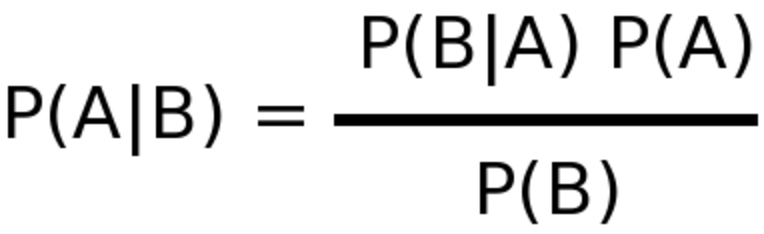

**Jupyter内嵌的图片需要使用html元素height和weight限制大小，markdown的-c扩展不起作用，不做修改**

* `P(A)`：A 独立发生的先验概率。在我们的示例中为 `P(D)`，该值已经提供给我们了 。

* `P(B)`：B 独立发生的先验概率。在我们的示例中为 `P(Pos)`。

* `P(A|B)`：在给定 B 的情况下 A 发生的后验概率，在我们的示例中为 `P(D|Pos)`，即**某人的测试结果为阳性时患有糖尿病的概率。这是我们要计算的值。**

* `P(B|A)`：在给定 A 的情况下 B 可能发生的概率。在我们的示例中为 `P(Pos|D)`，该值已经提供给我们了 。

将这些值代入贝叶斯定理公式中：

`P(D|Pos) = P(D) * P(Pos|D) / P(Pos)`

获得阳性测试结果 `P(Pos)` 的概率可以使用敏感性和特异性来计算，如下所示：

`P(Pos) = [P(D) * Sensitivity] + [P(~D) * (1-Specificity))]`

In [40]:
'''
Instructions:
Calculate probability of getting a positive test result, P(Pos)
'''

'\nInstructions:\nCalculate probability of getting a positive test result, P(Pos)\n'

In [41]:
'''
Solution (skeleton code will be provided)
'''
# P(D)
p_diabetes = 0.01

# P(~D)
p_no_diabetes = 0.99

# Sensitivity or P(Pos|D)
p_pos_diabetes = 0.9

# Specificity or P(Neg/~D)
p_neg_no_diabetes = 0.9

# P(Pos)
p_pos = (p_diabetes * p_pos_diabetes) + (p_no_diabetes * (1 - p_neg_no_diabetes))
print('The probability of getting a positive test result P(Pos) is: {}',format(p_pos))

The probability of getting a positive test result P(Pos) is: {} 0.10799999999999998


**我们可以利用所有这些信息计算后验概率，如下所示：**
​    
某人测试结果为阳性时患有糖尿病的概率为：

`P(D|Pos) = (P(D) * Sensitivity)) / P(Pos)`

某人测试结果为阳性时没有糖尿病的概率为：

`P(~D|Pos) = (P(~D) * (1-Specificity)) / P(Pos)`

后验概率的和将始终为 `1`。

In [43]:
'''
Instructions:
Compute the probability of an individual having diabetes, given that, that individual got a positive test result.
In other words, compute P(D|Pos).

The formula is: P(D|Pos) = (P(D) * P(Pos|D) / P(Pos)
'''

'\nInstructions:\nCompute the probability of an individual having diabetes, given that, that individual got a positive test result.\nIn other words, compute P(D|Pos).\n\nThe formula is: P(D|Pos) = (P(D) * P(Pos|D) / P(Pos)\n'

In [44]:
'''
Solution
'''
# P(D|Pos)
p_diabetes_pos = (p_diabetes * p_pos_diabetes) / p_pos
print('Probability of an individual having diabetes, given that that individual got a positive test result is:\
',format(p_diabetes_pos)) 

Probability of an individual having diabetes, given that that individual got a positive test result is: 0.08333333333333336


In [45]:
'''
Instructions:
Compute the probability of an individual not having diabetes, given that, that individual got a positive test result.
In other words, compute P(~D|Pos).

The formula is: P(~D|Pos) = (P(~D) * P(Pos|~D) / P(Pos)

Note that P(Pos/~D) can be computed as 1 - P(Neg/~D). 

Therefore:
P(Pos/~D) = p_pos_no_diabetes = 1 - 0.9 = 0.1
'''

'\nInstructions:\nCompute the probability of an individual not having diabetes, given that, that individual got a positive test result.\nIn other words, compute P(~D|Pos).\n\nThe formula is: P(~D|Pos) = (P(~D) * P(Pos|~D) / P(Pos)\n\nNote that P(Pos/~D) can be computed as 1 - P(Neg/~D). \n\nTherefore:\nP(Pos/~D) = p_pos_no_diabetes = 1 - 0.9 = 0.1\n'

In [47]:
'''
Solution
'''
# P(Pos/~D)
p_pos_no_diabetes = 0.1

# P(~D|Pos)
p_no_diabetes_pos = (p_no_diabetes * p_pos_no_diabetes) / p_pos
print('Probability of an individual not having diabetes, given that that individual got a positive test result is:'\
,p_no_diabetes_pos)

Probability of an individual not having diabetes, given that that individual got a positive test result is: 0.9166666666666669


恭喜！你从头实现了贝叶斯定理。你的分析表明即使某人的测试结果为阳性，他/她也有 8.3% 的概率实际上患有糖尿病，以及 91.67% 的概率没有糖尿病。当然前提是全球只有 1% 的人群患有糖尿病，这只是个假设。

**“朴素贝叶斯”中的“朴素”一词是什么意思？** 

朴素贝叶斯中的“朴素”一词实际上是指，算法在进行预测时使用的特征相互之间是独立的，但实际上并非始终这样。在我们的糖尿病示例中，我们只考虑了一个特征，即测试结果。假设我们添加了另一个特征“锻炼”。假设此特征具有二元值 `0` 和 `1`，0 表示某人一周的锻炼时间不超过 2 天，1 表示某人一周的锻炼时间超过 2 天。如果我们要同时使用这两个特征（即测试结果和“锻炼”特征的值）计算最终概率，贝叶斯定理将不可行。朴素贝叶斯是贝叶斯定理的一种延伸，假设所有特征相互之间是独立的。

### 第 4.2 步：从头实现朴素贝叶斯 ###

你已经知道贝叶斯定理的详细原理，现在我们将用它来考虑有多个特征的情况。

假设有两个政党的候选人，“Jill Stein”是绿党候选人，“Gary Johnson”是自由党的候选人，两位候选人在演讲中提到“自由”、“移民”和“环境”这些字眼的概率为：

* Jill Stein 提到“自由”的概率：0.1 ---------> `P(F|J)`
* Jill Stein 提到“移民”的概率：0.1 -----> `P(I|J)`
* Jill Stein 提到“环境”的概率：0.8 -----> `P(E|J)`


* Gary Johnson 提到“自由”的概率：0.7 -------> `P(F|G)`
* Gary Johnson 提到“移民”的概率：0.2 ---> `P(I|G)`
* Gary Johnson 提到“环境”的概率：0.1 ---> `P(E|G)`


假设 Jill Stein 发表演讲的概率 `P(J)` 是 `0.5`，Gary Johnson 也是 `P(G) = 0.5`。


了解这些信息后，如果要计算 Jill Stein 提到“自由”和“移民”的概率呢？这时候朴素贝叶斯定理就派上用场了，我们将考虑两个特征：“自由”和“移民”。

现在我们可以定义朴素贝叶斯定理的公式：

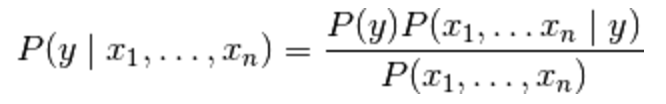

在该公式中，`y` 是分类变量，即候选人的姓名，`x1` 到 `xn` 是特征向量，即单个单词。该定理假设每个特征向量或单词 (`xi`) 相互之间是独立的。

为了详细讲解该公式，我们需要计算以下后验概率：

* `P(J|F,I)`：Jill Stein 提到“自由”和“移民”的概率。

根据上述公式和贝叶斯定理，我们可以进行以下计算：`P(J|F,I)` = `(P(J) * P(F|J) * P(I|J)) / P(F,I)`。在此等式中，`P(F,I)` 是在研究中提到“自由”和“移民”的概率。


* `P(G|F,I)`：Gary Johnson 提到“自由”和“移民”的概率。

In [50]:
'''
Instructions: Compute the probability of the words 'freedom' and 'immigration' being said in a speech, or
P(F,I).

The first step is multiplying the probabilities of Jill Stein giving a speech with her individual 
probabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_j_text

The second step is multiplying the probabilities of Gary Johnson giving a speech with his individual 
probabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_g_text

The third step is to add both of these probabilities and you will get P(F,I).
'''

"\nInstructions: Compute the probability of the words 'freedom' and 'immigration' being said in a speech, or\nP(F,I).\n\nThe first step is multiplying the probabilities of Jill Stein giving a speech with her individual \nprobabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_j_text\n\nThe second step is multiplying the probabilities of Gary Johnson giving a speech with his individual \nprobabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_g_text\n\nThe third step is to add both of these probabilities and you will get P(F,I).\n"

In [51]:
'''
Solution: Step 1
'''
# P(J)
p_j = 0.5

# P(F/J)
p_j_f = 0.1

# P(I/J)
p_j_i = 0.1

p_j_text = p_j * p_j_f * p_j_i
print(p_j_text)

0.005000000000000001


In [52]:
'''
Solution: Step 2
'''
# P(G)
p_g = 0.5

# P(F/G)
p_g_f = 0.7

# P(I/G)
p_g_i = 0.2

p_g_text = p_g * p_g_f * p_g_i
print(p_g_text)

0.06999999999999999


In [53]:
'''
Solution: Step 3: Compute P(F,I) and store in p_f_i
'''
p_f_i = p_j_text + p_g_text
print('Probability of words freedom and immigration being said are: ', format(p_f_i))

Probability of words freedom and immigration being said are:  0.075


现在可以计算 `P(J|F,I)` 的概率，即 Jill Stein 提到“自由”和“移民”的概率，以及 `P(G|F,I)`，即 Gary Johnson 提到“自由”和“移民”的概率。

In [54]:
'''
Instructions:
Compute P(J|F,I) using the formula P(J|F,I) = (P(J) * P(F|J) * P(I|J)) / P(F,I) and store it in a variable p_j_fi
'''

'\nInstructions:\nCompute P(J|F,I) using the formula P(J|F,I) = (P(J) * P(F|J) * P(I|J)) / P(F,I) and store it in a variable p_j_fi\n'

In [55]:
'''
Solution
'''
p_j_fi = p_j_text / p_f_i
print('The probability of Jill Stein saying the words Freedom and Immigration: ', format(p_j_fi))

The probability of Jill Stein saying the words Freedom and Immigration:  0.06666666666666668


In [56]:
'''
Instructions:
Compute P(G|F,I) using the formula P(G|F,I) = (P(G) * P(F|G) * P(I|G)) / P(F,I) and store it in a variable p_g_fi
'''

'\nInstructions:\nCompute P(G|F,I) using the formula P(G|F,I) = (P(G) * P(F|G) * P(I|G)) / P(F,I) and store it in a variable p_g_fi\n'

In [57]:
'''
Solution
'''
p_g_fi = p_g_text / p_f_i
print('The probability of Gary Johnson saying the words Freedom and Immigration: ', format(p_g_fi))

The probability of Gary Johnson saying the words Freedom and Immigration:  0.9333333333333332


可以看出，和贝叶斯定理一样，后验概率之和等于 1。恭喜！你从头实现了朴素贝叶斯定理。分析表明，绿党的 Jill Stein 在演讲中提到“自由”和“移民”的概率只有 6.6%，而自由党的 Gary Johnson 有 93.3% 的可能性会提到这两个词。

另一个比较常见的朴素贝叶斯定理应用示例是在搜索引擎中搜索“萨克拉门托国王”。为了使我们能够获得与萨克拉门托国王队 NBA 篮球队相关的结果，搜索引擎需要将这两个单词关联到一起，而不是单独处理它们，否则就会获得标有“萨克拉门托”的图片（例如风光图片）以及关于“国王”的图片（可能是历史上的国王），而实际上我们想要搜索的是关于篮球队的图片。这是一种搜索引擎将单词当做非独立个体（因此采用的是“朴素”方式）的经典示例。 


将此方法应用到我们的垃圾信息分类问题上，朴素贝叶斯算法会查看每个单词，而不是将它们当做有任何联系的关联体。对于垃圾内容检测器来说，这么做通常都可行，因为有些禁用词几乎肯定会被分类为垃圾内容，例如包含“伟哥”的电子邮件通常都被归类为垃圾邮件。

### 第 5 步：使用 scikit-learn 实现朴素贝叶斯 ###

幸运的是，sklearn 具有多个朴素贝叶斯实现，这样我们就不用从头进行计算。我们将使用 sklearns 的 `sklearn.naive_bayes` 方法对我们的数据集做出预测。

具体而言，我们将使用多项式朴素贝叶斯实现。这个分类器适合分类离散特征（例如我们的单词计数文本分类）。它会将整数单词计数作为输入。另一方面，高斯朴素贝叶斯更适合连续数据，因为它假设输入数据是高斯（正态）分布。

In [58]:
'''
Instructions:

We have loaded the training data into the variable 'training_data' and the testing data into the 
variable 'testing_data'.

Import the MultinomialNB classifier and fit the training data into the classifier using fit(). Name your classifier
'naive_bayes'. You will be training the classifier using 'training_data' and y_train' from our split earlier. 
'''

"\nInstructions:\n\nWe have loaded the training data into the variable 'training_data' and the testing data into the \nvariable 'testing_data'.\n\nImport the MultinomialNB classifier and fit the training data into the classifier using fit(). Name your classifier\n'naive_bayes'. You will be training the classifier using 'training_data' and y_train' from our split earlier. \n"

In [59]:
'''
Solution
'''
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [60]:
'''
Instructions:
Now that our algorithm has been trained using the training data set we can now make some predictions on the test data
stored in 'testing_data' using predict(). Save your predictions into the 'predictions' variable.
'''

"\nInstructions:\nNow that our algorithm has been trained using the training data set we can now make some predictions on the test data\nstored in 'testing_data' using predict(). Save your predictions into the 'predictions' variable.\n"

In [61]:
'''
Solution
'''
predictions = naive_bayes.predict(testing_data)

我们已经对测试集进行预测，现在需要检查预测的准确率了。

### 第 6 步：评估模型 ###

我们已经对测试集进行了预测，下一个目标是评估模型的效果。我们可以采用各种衡量指标，但首先快速总结下这些指标。

**准确率**衡量的是分类器做出正确预测的概率，即正确预测的数量与预测总数（测试数据点的数量）之比。

**精确率**指的是分类为垃圾信息的信息实际上是垃圾信息的概率，即真正例（分类为垃圾内容并且实际上是垃圾内容的单词）与所有正例（所有分类为垃圾内容的单词，无论是否分类正确）之比，换句话说，是以下公式的比值结果：

`[True Positives/(True Positives + False Positives)]`

**召回率（敏感性**表示实际上为垃圾信息并且被分类为垃圾信息的信息所占比例，即真正例（分类为垃圾内容并且实际上是垃圾内容的单词）与所有为垃圾内容的单词之比，换句话说，是以下公式的比值结果：

`[True Positives/(True Positives + False Negatives)]`

对于偏态分类分布问题（我们的数据集就属于偏态分类），例如如果有 100 条信息，只有 2 条是垃圾信息，剩下的 98 条不是，则准确率本身并不是很好的指标。我们将 90 条信息分类为垃圾信息（包括 2 条垃圾信息，但是我们将其分类为非垃圾信息，因此它们属于假负例），并将 10 条信息分类为垃圾信息（所有 10 条都是假正例），依然会获得比较高的准确率分数。对于此类情形，精确率和召回率非常实用。可以通过这两个指标获得 F1 分数，即精确率和召回率分数的加权平均值。该分数的范围是 0 到 1，1 表示最佳潜在 F1 分数。

我们将使用所有四个指标确保我们的模型效果很好。这四个指标的值范围都在 0 到 1 之间，分数尽量接近 1 可以很好地表示模型的效果如何。

In [62]:
'''
Instructions:
Compute the accuracy, precision, recall and F1 scores of your model using your test data 'y_test' and the predictions
you made earlier stored in the 'predictions' variable.
'''

"\nInstructions:\nCompute the accuracy, precision, recall and F1 scores of your model using your test data 'y_test' and the predictions\nyou made earlier stored in the 'predictions' variable.\n"

In [63]:
'''
Solution
'''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.9885139985642498
Precision score:  0.9720670391061452
Recall score:  0.9405405405405406
F1 score:  0.9560439560439562


### 第 7 步：总结 ###

和其他分类算法相比，朴素贝叶斯具有的一大主要优势是能够处理大量特征。在我们的示例中，有数千个不同的单词，每个单词都被当做一个特征。此外，即使存在不相关的特征也有很好的效果，不容易受到这种特征的影响。另一个主要优势是相对比较简单。朴素贝叶斯完全可以直接使用，很少需要调整参数，除非通常分布数据已知的情况需要调整。
它很少会过拟合数据。另一个重要优势是相对于它能处理的数据量来说，训练和预测速度很快。总之，朴素贝叶斯是非常实用的算法！

恭喜！你成功地设计了一个可以有效地预测信息是否为垃圾信息的模型！

感谢你与我们一起学习这些知识！